# SEAIRT con curve_fit dei parametri

In questo modello compartimentale, abbiamo considerato un tempo di incubazione (_Exposed_) per gli individui _Susceptible_ che dovranno diventare o _Asymptomatic_ o _Infected_, in quanto contagiati tramite un contatto infettivo. Una frazione degli _Infected_ sarà quindi ammessa in ospedale (_Ricoverati_) o direttamente in un reparto di terapia intensiva (_Terapia_). I dati utilizzati per calibrare il modello sono pubblici e condivisi quotidianamente qui: https://github.com/pcm-dpc/COVID-19 .


Dai dati, si sono prese in considerazione 3 curve epidemiologiche: _nuovi_positivi_, _ricoverati_con_sintomi_ e _terapia_intensiva_.
Usando queste curve, si sono calibrati 3 parametri del modello:

_beta_: tasso giornaliero di nuovi contagiati per singolo infetto). 

_pric_: frazione degli infetti che necessita un ricovero.

_pt_: frazione dei ricoverati che necessita la terapia intensiva.


Dall'inizio dell'epidemia, in Italia sono entrate in vigore misure legislative che hanno condizionato fortemente la mobilità, il numero di contatti tra persone e le precauzioni nei contatti stessi. Per questo motivo, tali periodi verranno calibrati sui dati indipendentemente l'uno dall'altro, in quando ci attendiamo che il parametro _beta_, che descrive il tasso giornaliero di nuovi contagiati per singolo infetto sia fortemente dipendente da tali misure di contenimento del virus. Anche altri parametri, come la percentuale di infetti ricoverati, sarà calibrata nelle diverse finestre temporali, in modo da catturare il fatto che nel tempo il criterio in base al quale fare un tampone è cambiato, e con esso anche la percentuale di ricoveri in seguito ad un tampone positivo. In particolare, ci aspettiamo che il valore di tale frazione sia prossimo a 1 all'inizio, quando si era a conoscenza solo di infetti con sintomi gravi.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import multiprocessing as mp
import pickle
from datetime import date
import matplotlib.dates as mdates
import requests
import json
import os
from datetime import date
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp,odeint
import scipy.stats as st
import math
from functools import partial
import urllib.request

In [2]:
regione='Emilia-Romagna'
data=pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
data.set_index(pd.to_datetime(data.data).dt.date,inplace=True,drop=True)
data=data[data.denominazione_regione==regione]
data.drop(['denominazione_regione','codice_regione','data','stato','casi_da_sospetto_diagnostico','note','lat','long',
           'tamponi','casi_testati','casi_da_screening',
           'variazione_totale_positivi','note_casi','note_test',
          'tamponi_test_molecolare','tamponi_test_antigenico_rapido'],axis=1,inplace=True)
print(data.columns)

Index(['ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati',
       'isolamento_domiciliare', 'totale_positivi', 'nuovi_positivi',
       'dimessi_guariti', 'deceduti', 'totale_casi',
       'ingressi_terapia_intensiva', 'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'codice_nuts_1',
       'codice_nuts_2'],
      dtype='object')


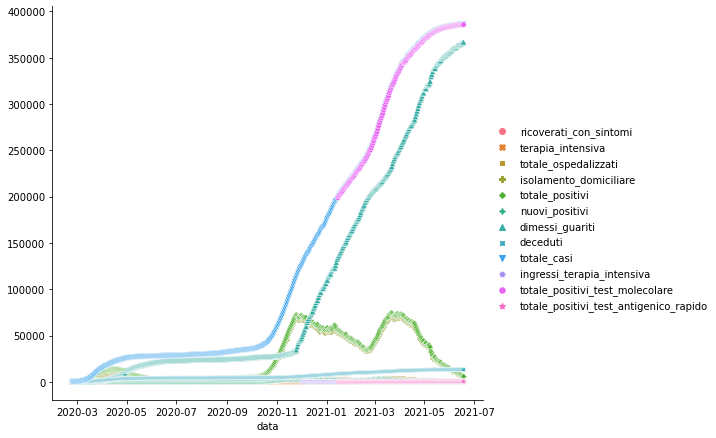

In [3]:
#Data inspection
g=sns.relplot(data=data,height=6,aspect=1.2)

In [4]:
start=pd.to_datetime(data.index.min())
end=pd.to_datetime(data.index.max())
print('Periodo da: ',start,'\n a: ', end)
if (not (end-start).days==data.shape[0]-1) or data.index.duplicated(keep=False).sum()>0:
    print('Errore nei dati: giorni di troppo o giorni mancanti')

Periodo da:  2020-02-24 00:00:00 
 a:  2021-06-18 00:00:00


In [5]:
data_fit=data[['nuovi_positivi','totale_positivi','isolamento_domiciliare',
               'ricoverati_con_sintomi','terapia_intensiva']].copy()
data_fit['totale_casi']=data.nuovi_positivi.cumsum()
#print(data_fit.shape)
#data_fit

## Esplorazione dati

/home/PERSONALE/francesco.durazzi2/anaconda3/envs/mobi/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


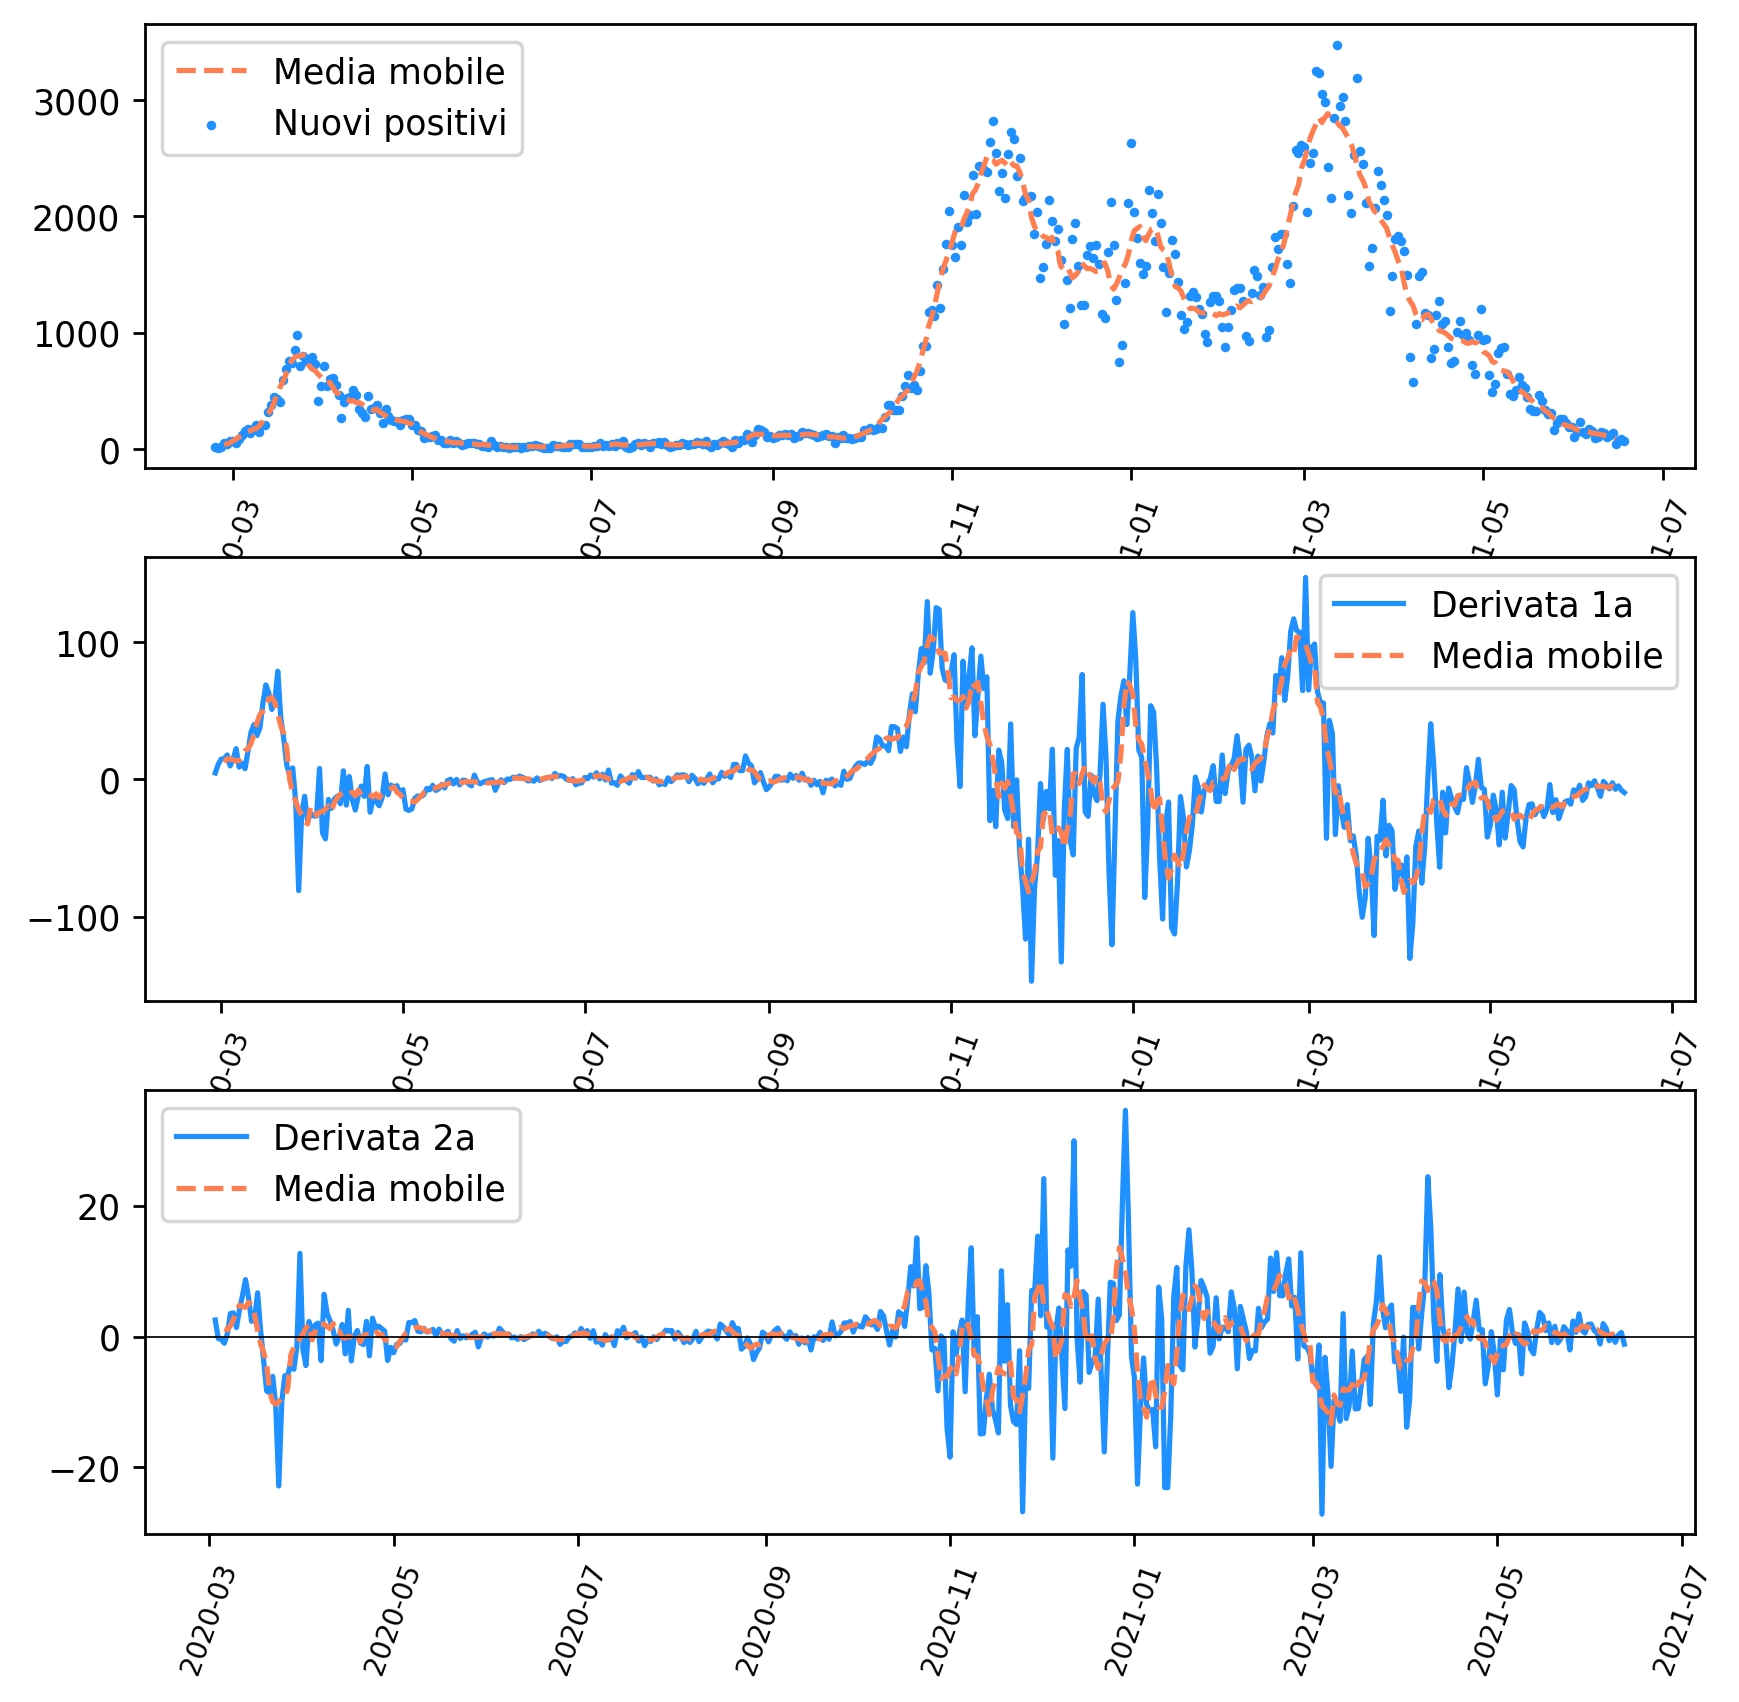

In [6]:
wlen=7
data_fit['nuovi_pos_avg']=np.nan
data_fit['nuovi_pos_avg'].iloc[int(wlen/2):-int(wlen/2)]=np.convolve(data_fit['nuovi_positivi'],np.ones(wlen,)/wlen,'valid')

data_fit['deriv1']=np.diff(data_fit.nuovi_pos_avg,prepend=0)
data_fit['d1_avg']=np.nan
data_fit['d1_avg'].iloc[int(wlen/2):-int(wlen/2)]=np.convolve(data_fit['deriv1'],np.ones(wlen,)/wlen,'valid')

data_fit['deriv2']=np.diff(data_fit.d1_avg,prepend=0)
data_fit['d2_avg']=np.nan
data_fit['d2_avg'].iloc[int(wlen/2):-int(wlen/2)]=np.convolve(data_fit['deriv2'],np.ones(wlen,)/wlen,'valid')

f,axs=plt.subplots(3,1,dpi=250,figsize=(8,8))
axs[0].scatter(data_fit.index,data_fit.nuovi_positivi,label='Nuovi positivi',s=3,color='dodgerblue')
axs[0].plot(data_fit.index,data_fit.nuovi_pos_avg,'--',label='Media mobile',color='coral')

axs[1].plot(data_fit.index,data_fit.deriv1,label='Derivata 1a',color='dodgerblue')
axs[1].plot(data_fit.index,data_fit.d1_avg,'--',label='Media mobile',color='coral')

axs[2].plot(data_fit.index,data_fit.deriv2,label='Derivata 2a',color='dodgerblue')
axs[2].plot(data_fit.index,data_fit.d2_avg,'--',label='Media mobile',color='coral')
axs[2].axhline(0,color='black',linewidth=.5)

for ax in axs:
    ax.legend()
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=70,fontsize=8 )

Oltre al numero di persone attualmente positive (I), teniamo traccia anche del numero cumulativo di infetti (In). Dalla differenza giornaliera di tale curva, possiamo poi ricavare la serie giornaliera dei nuovi infetti, da fittare sui dati.

In [7]:
# Funzione derivata da fornire a solve_ivp
def SIR_ode(t,x,beta,alpha,eps,mui,gammar,gammat,pt,pric):
        S,E,A,I,In,C,R,T=x#,G,D=x
        
        dS=-beta*S*(I+A)/N
        dE=beta*S*(I+A)/N-eps*E
        dA=(1-alpha)*eps*E-mui*A
        dI=alpha*eps*E-mui*I
        dIn=alpha*eps*E
        dC=(1-pric)*mui*I-gammar*C
        dR=pric*(1-pt)*mui*I-gammar*R
        dT=pric*pt*mui*I-gammat*T
        
        return [dS,dE,dA,dI,dIn,dC,dR,dT]

def SIRinteg(x0p,ttotp,ti,beta,pric,pt):
      
    sol=solve_ivp(SIR_ode,[ttotp[0],ttotp[-1]],x0p,args=(beta,alpha,eps,mui,gammar,
                                                gammat,pt,pric),t_eval=ttotp)
    lung=len(sol.y[0])
    
    return np.concatenate((np.diff(sol.y[4],prepend=x0p[4]).reshape(lung,1),
                           #sol.y[5].reshape(lung,1),
                           sol.y[6].reshape(lung,1),
                           sol.y[7].reshape(lung,1)),axis=1).flatten()


# Simulazione

Le condizioni iniziale sono prese dai dati, con due eccezioni.
La prima è il numero di suscettibili all'inizio, che viene impostato come la popolazione italiana tolti gli individui assegnati agli altri compartimenti.
La seconda è il numero di individui in incubazione all'inizio, che fissiamo a 0, per quanto verosimilmente maggiore.

Non utilizziamo per il fit i dati relativi agli ultimi 7 giorni, in modo da utilizzarli poi come test set per valutare l'accuratezza predittiva del modello.

In [8]:
#Durata predizioni
predlen=120
# Fitta anche curve senza tenere conto degli ultimi giorni
test_size=7
#Dopo quanto tempo si vedono gli effetti dei DPCM
delay=7

days_tot=len(pd.date_range(start,end))
tempo_tot=np.linspace(0,days_tot,days_tot+1)
N=4459000
x0=[N,data_fit.totale_positivi.iloc[0],data_fit.totale_positivi.iloc[0],data_fit.totale_positivi.iloc[0],
    0,data_fit.isolamento_domiciliare.iloc[0],
    data_fit.ricoverati_con_sintomi.iloc[0],data_fit.terapia_intensiva.iloc[0]]
x0[0]=N-sum(x0[1:])
x0[4]=data_fit.totale_casi.iloc[0]

#Valori iniziali per la calibrazione:
beta=1/1.3
pric=0.5

#Parametri fissati:
#Frazione di sintomatici su totale infetti
alpha=0.15
#Tempo di incubazione
eps=1/2
#Tempo di permanenza in Infetti
mui=1/5.5
#Tempo di degenza in ospedale per chi non necessita terapia intensiva
gammar=1/25
#Tempo di degenza in terapia intensiva
gammat=1/6.5
#Frazione di ricoverati che necessita la terapia intensiva
pt=0.3

dshift=(start-pd.to_datetime('2020-01-01')).days
#Giorni in cui cambiano le misure restrittive:
#(contati dall'inizio dell'anno: 1gennaio2020 = 0)
dvec=[0,70,82+delay,124+delay,138+delay,154+delay,166+delay,180+delay,251+delay,292+delay,304+delay,345+delay,
      365+38+delay,365+52+delay,365+74+delay,365+111+delay,
      days_tot+dshift-1]
dvec=[d-dshift for d in dvec]
dvec[0]=0
#print('dvec: ',dvec)

#Moltiplicatore di mobilità rispetto al periodo iniziale (da calibrare tramite beta)
mobs=[1,0.47,0.25,0.19,0.19,0.2,0.2,0.24,0.49,0.3,0.2,0.3,
     0.35,0.3,0.3,0.2]
betas=[beta*m for m in mobs]
#print('betas: ',betas)

popts=[]
pcovs=[]
integs=[]
for i,beta in enumerate(betas):
    dtotp=dvec[i+1]-dvec[i]
    ttotp=tempo_tot[dvec[i]:dvec[i+1]]
    ttotpred=tempo_tot[dvec[i]:dvec[i+1]+1]
    startp=data_fit.iloc[dvec[i]].name
    endp=data_fit.iloc[dvec[i+1]-1].name
    #if i>2:
    #    pric=0.3
    if i==len(betas)-1:
        dtotp=dvec[i+1]-dvec[i]+1
        ttotp=tempo_tot[dvec[i]:dvec[i+1]+1]
        endp=data_fit.iloc[dvec[i+1]].name
        ttotpred=np.linspace(dvec[i],dvec[i+1]+predlen,dtotp+predlen+1)
    print('\nFitting from {} to {}'.format(startp,endp))
    x0p=x0
    if not i==0:
        x0p=[integ.y[j][-1] for j in range(len(integ.y))]
    #print('x0: ',x0p)
    
    fintegranda=partial(SIRinteg,x0p,ttotp)
    popt, pcov = curve_fit(fintegranda, ttotp, 
                       np.array(data_fit.loc[startp:endp,['nuovi_positivi',
                                                          #'isolamento_domiciliare',
                                                          'ricoverati_con_sintomi',
                                                         'terapia_intensiva']].values).flatten(),
                       p0=[beta,pric,pt],maxfev=5000,bounds=([0.,0.,0.],
                                                              [2.5,1.,1.]))
    popts.append(popt)
    pcovs.append(pcov)
    integ=solve_ivp(SIR_ode,[ttotpred[0],ttotpred[-1]],x0p,
                args=(popt[0],alpha,eps,mui,gammar,gammat,popt[2],popt[1]),
                t_eval=ttotpred)
    integs.append(integ)
    #print('xfinal: ',[integ.y[j][-1] for j in range(len(integ.y))])
    #print('Ninf: ',integ.y[4][-1]-integ.y[4][-2])
    print('beta: ',popt[0])
    print('m (beta): ',popt[0]/popts[0][0])
    print('R0 (beta):',popt[0]/mui )
    print('prob intensiva:',popt[2] )
    print('prob ricovero:',popt[1] )


res=pd.DataFrame()
res['Susceptible']=np.concatenate([integ.y[0][:-1] for integ in integs])
res['Exposed']=np.concatenate([integ.y[1][:-1] for integ in integs])
res['Asymptomatic']=np.concatenate([integ.y[2][:-1] for integ in integs])
res['Infected']=np.concatenate([integ.y[3][:-1] for integ in integs])
res['ICumulative']=np.concatenate([integ.y[4][:-1] for integ in integs])
res['IsolamentoDomiciliare']=np.concatenate([integ.y[5][:-1] for integ in integs])
res['Ricoverati']=np.concatenate([integ.y[6][:-1] for integ in integs])
res['Terapia']=np.concatenate([integ.y[7][:-1] for integ in integs])
#I nuovi infetti giornalieri sono la differenza della curva cumulativa:
res['NInf']=np.diff(res['ICumulative'],prepend=0)
res['Day']=pd.date_range(start,end+pd.Timedelta(predlen,'D'))
res['Nday']=list(range(dvec[0]+dshift,dvec[-1]+dshift+predlen+1))
res['Rt']=np.concatenate([np.repeat(popts[i][0]/mui,len(integs[i].y[0][:-1])) 
                         for i in range(len(integs))])

res.set_index('Day',inplace=True)

print('\n betas fitted: ',[popt[0] for popt in popts])
print('\n m fitted: ',[popt[0]/popts[0][0] for popt in popts])
print('\n R0 fitted:',[popt[0]/mui for popt in popts])
print('\n prob intensiva fitted:',[popt[2] for popt in popts])
print('\n prob ricovero fitted:',[popt[1] for popt in popts])

#Diversi scenari con socialità al 110% e al 90% dell'attuale
integ=solve_ivp(SIR_ode,[ttotpred[0],ttotpred[-1]],x0p,
                args=(popt[0]*1.1,alpha,eps,mui,gammar,gammat,popt[2],popt[1]),
                t_eval=ttotpred)
res['WS_NuoviCasi']=np.nan
res.iloc[-len(integ.y[0])+1:,-1]=np.diff(integ.y[4])
res['WS_Ricoverati']=np.nan
res.iloc[-len(integ.y[0]):,-1]=integ.y[6]
res['WS_TerapiaIntensiva']=np.nan
res.iloc[-len(integ.y[0]):,-1]=integ.y[7]

integ=solve_ivp(SIR_ode,[ttotpred[0],ttotpred[-1]],x0p,
                args=(popt[0]*.9,alpha,eps,mui,gammar,gammat,popt[2],popt[1]),
                t_eval=ttotpred)
res['BS_NuoviCasi']=np.nan
res.iloc[-len(integ.y[0])+1:,-1]=np.diff(integ.y[4])
res['BS_Ricoverati']=np.nan
res.iloc[-len(integ.y[0]):,-1]=integ.y[6]
res['BS_TerapiaIntensiva']=np.nan
res.iloc[-len(integ.y[0]):,-1]=integ.y[7]

#Previsioni senza contare gli ultimi 7 giorni (test_size)
#Possibile solo se si è più di 7 giorni dopo il cambio di mobilità
if len(ttotp)>7:
    ttotp=tempo_tot[dvec[len(betas)-1]:dvec[len(betas)]+1-test_size]
    endp=data_fit.iloc[dvec[len(betas)]-test_size].name
    fintegranda=partial(SIRinteg,x0p,ttotp)
    popt, pcov = curve_fit(fintegranda, ttotp, 
                           np.array(data_fit.loc[startp:endp,['nuovi_positivi',
                                                              #'isolamento_domiciliare',
                                                              'ricoverati_con_sintomi',
                                                             'terapia_intensiva']].values).flatten(),
                           p0=[beta,pric,pt],maxfev=5000,bounds=([0.,0.,0.],
                                                                  [2.5,1.,1.]))
    integ_test=solve_ivp(SIR_ode,[ttotpred[0],ttotpred[-1]],x0p,
                    args=(popt[0],alpha,eps,mui,gammar,gammat,popt[2],popt[1]),
                    t_eval=ttotpred)
    res['TestNInf']=np.nan
    res.iloc[-len(integ_test.y[0])+1:,-1]=np.diff(integ_test.y[4])
    res['TestRicoverati']=np.nan
    res.iloc[-len(integ_test.y[0]):,-1]=integ_test.y[6]
    res['TestTerapia']=np.nan
    res.iloc[-len(integ_test.y[0]):,-1]=integ_test.y[7]
    tested=True
else:
    print('\nNon è possibile fare testing su così pochi giorni dall\'ultimo cambio di mobilità')
    tested=False


Fitting from 2020-02-24 to 2020-03-10
beta:  0.9573214569087497
m (beta):  1.0
R0 (beta): 5.265268012998123
prob intensiva: 1.2884990604879917e-12
prob ricovero: 0.9999999999999118

Fitting from 2020-03-11 to 2020-03-29
beta:  0.23355780583656474
m (beta):  0.24397009400660188
R0 (beta): 1.284567932101106
prob intensiva: 0.17093923079600218
prob ricovero: 0.5722685108722704

Fitting from 2020-03-30 to 2020-05-10
beta:  0.12361009827759212
m (beta):  0.12912078527596862
R0 (beta): 0.6798555405267567
prob intensiva: 0.3555712251228225
prob ricovero: 0.26400336265695923

Fitting from 2020-05-11 to 2020-05-24
beta:  0.11317587068051033
m (beta):  0.11822138725059211
R0 (beta): 0.6224672887428068
prob intensiva: 0.9999999999999999
prob ricovero: 0.1908464832663911

Fitting from 2020-05-25 to 2020-06-09
beta:  0.11861045571578634
m (beta):  0.12389825262956797
R0 (beta): 0.6523575064368249
prob intensiva: 0.9999999999999999
prob ricovero: 0.15143591598486716

Fitting from 2020-06-10 to 2020

Nelle figure successive, la linea verticale arancione rappresenta il limite temporale dopo il quale non si sono considerati i dati per calibrare i parametri del modello. Tali dati sono quindi sconosciuti al modello e possono essere utilizzati per testarne l'effettiva capacità predittiva.

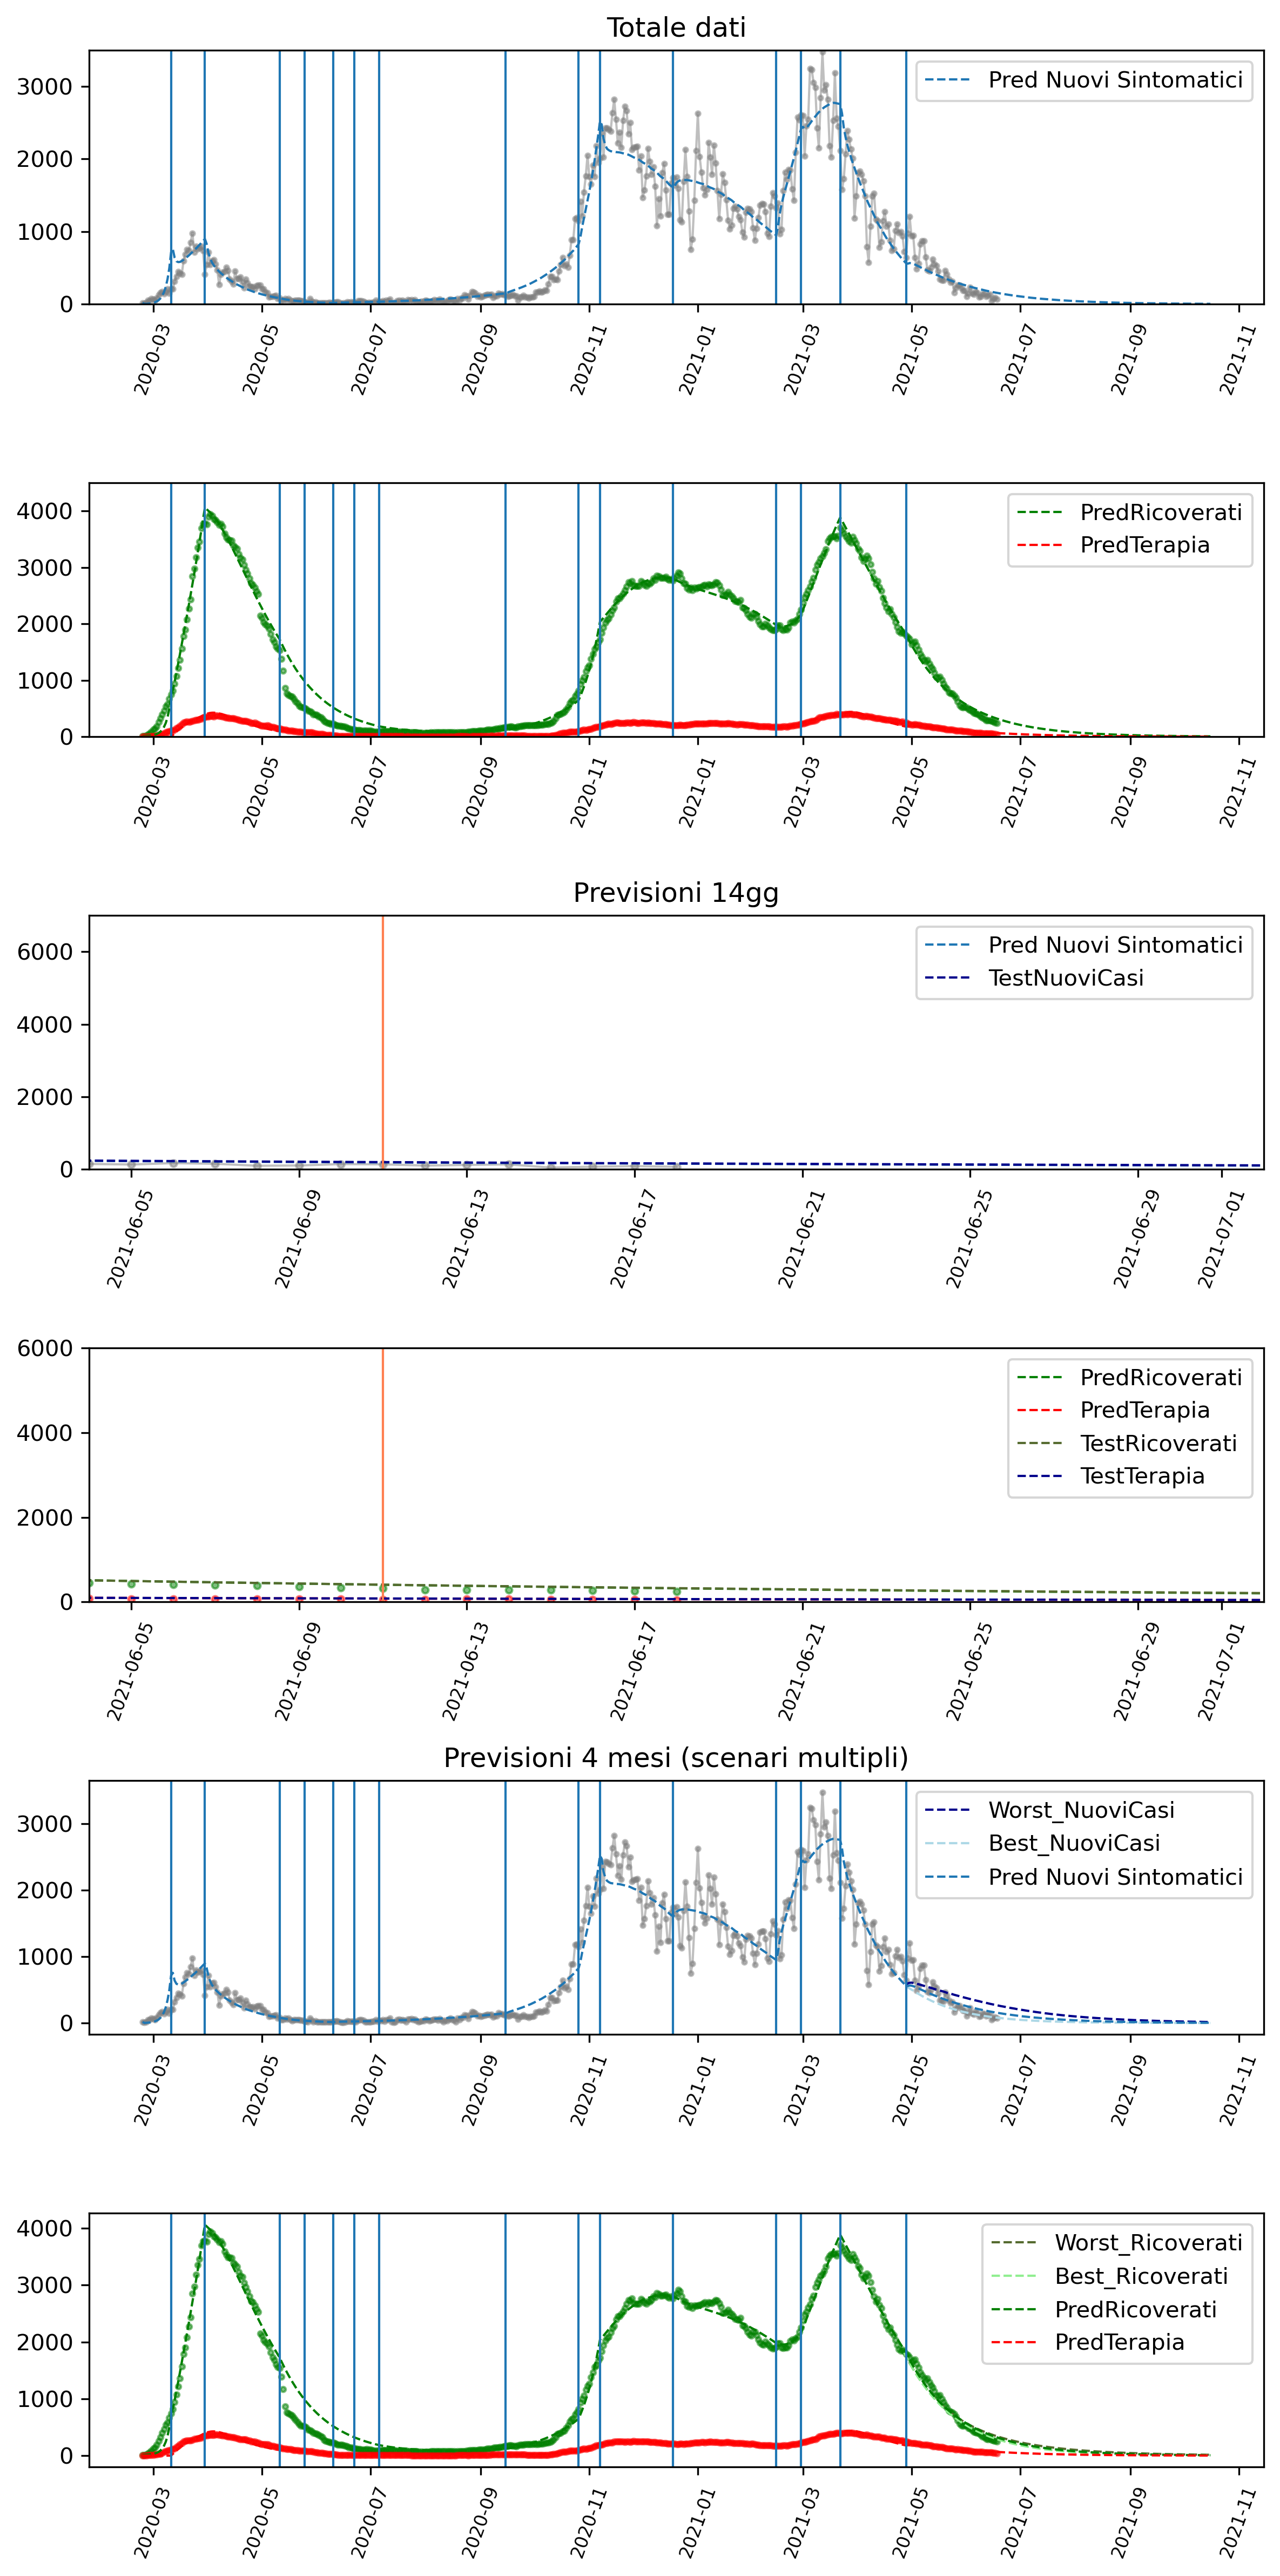

In [9]:
f,axs=plt.subplots(6,1,dpi=300,figsize=(8,16))
axs[0].plot(res.loc[start:end].index,data_fit.nuovi_positivi,'-o',alpha=.5,linewidth=1,c='grey',
           markersize=2)
axs[1].scatter(res.loc[start:end].index,data_fit.ricoverati_con_sintomi,alpha=.5,
               s=5,c='green')
axs[1].scatter(res.loc[start:end].index,data_fit.terapia_intensiva,alpha=.5,s=5,c='red')
axs[0].plot(res.index,res.NInf,'--',label='Pred Nuovi Sintomatici',linewidth=1)
axs[1].plot(res.index,res.Ricoverati,'--',label='PredRicoverati',c='green',linewidth=1)
axs[1].plot(res.index,res.Terapia,'--',label='PredTerapia',c='red',linewidth=1)

axs[2].plot(res.loc[start:end].index,data_fit.nuovi_positivi,'-o',alpha=.5,linewidth=1,c='grey',
           markersize=3)
axs[2].plot(res.index,res.NInf,'--',label='Pred Nuovi Sintomatici',linewidth=1)
axs[3].scatter(res.loc[start:end].index,data_fit.ricoverati_con_sintomi,alpha=.5,s=8,c='green')
axs[3].scatter(res.loc[start:end].index,data_fit.terapia_intensiva,alpha=.5,s=8,c='red')
axs[3].plot(res.index,res.Ricoverati,'--',label='PredRicoverati',c='green',linewidth=1)
axs[3].plot(res.index,res.Terapia,'--',label='PredTerapia',c='red',linewidth=1)
if tested:
    axs[2].plot(res.index,res.TestNInf,'--',label='TestNuoviCasi',c='darkblue',linewidth=1)
    axs[3].plot(res.index,res.TestRicoverati,'--',label='TestRicoverati',c='darkolivegreen',linewidth=1)
    axs[3].plot(res.index,res.TestTerapia,'--',label='TestTerapia',c='darkblue',linewidth=1)

axs[4].plot(res.loc[start:end].index,data_fit.nuovi_positivi,'-o',alpha=.5,linewidth=1,c='grey',
           markersize=2)
axs[4].plot(res.index,res.WS_NuoviCasi,'--',label='Worst_NuoviCasi',c='darkblue',linewidth=1)
axs[4].plot(res.index,res.BS_NuoviCasi,'--',label='Best_NuoviCasi',c='lightblue',linewidth=1)
axs[4].plot(res.index,res.NInf,'--',label='Pred Nuovi Sintomatici',linewidth=1)
axs[5].scatter(res.loc[start:end].index,data_fit.ricoverati_con_sintomi,alpha=.5,s=5,c='green')
axs[5].scatter(res.loc[start:end].index,data_fit.terapia_intensiva,alpha=.5,s=5,c='red')
axs[5].plot(res.index,res.WS_Ricoverati,'--',label='Worst_Ricoverati',c='darkolivegreen',linewidth=1)
axs[5].plot(res.index,res.BS_Ricoverati,'--',label='Best_Ricoverati',c='lightgreen',linewidth=1)
axs[5].plot(res.index,res.Ricoverati,'--',label='PredRicoverati',c='green',linewidth=1)
axs[5].plot(res.index,res.Terapia,'--',label='PredTerapia',c='red',linewidth=1)

for ax in axs:
    for dv in dvec[1:-1]:
        ax.axvline(res.index[dv], linewidth=1)
    ax.legend()
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=70,fontsize=8 )
axs[2].axvline(endp,linewidth=1,color='coral',label='Limite dati fittati')
axs[3].axvline(endp,linewidth=1,color='coral',label='Limite dati fittati')


axs[0].set_ylim(-1,3500)
axs[1].set_ylim(-1,4500)

today=date.today()
axs[2].set_xlim(today-pd.Timedelta(14,unit='D'),today+pd.Timedelta(14,unit='D'))
axs[2].set_ylim(-1,7000)
#axs[1].set_xlim(dshift,dshift+30)
axs[3].set_xlim(today-pd.Timedelta(14,unit='D'),today+pd.Timedelta(14,unit='D'))
axs[3].set_ylim(-1,6000)


#axs[4].set_xlim('2020-02-27','2020-03-15')
#axs[4].set_ylim(-1,5000)
#axs[1].set_xlim(dshift,dshift+30)
#axs[5].set_xlim('2020-02-27','2020-03-15')
#axs[5].set_ylim(-1,7000)

axs[0].set_title('Totale dati')
axs[2].set_title('Previsioni 14gg')
axs[4].set_title('Previsioni 4 mesi (scenari multipli)')
#plt.legend()
plt.tight_layout()

### Esplorazione parametri

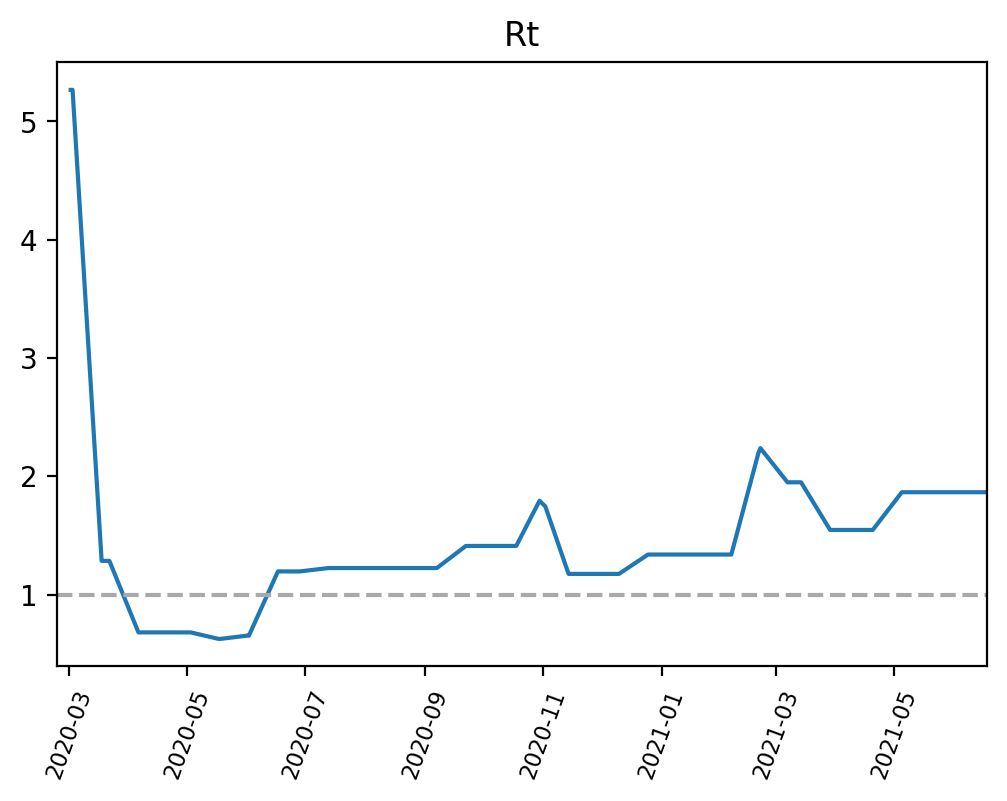

In [10]:
f,ax=plt.subplots(1,1,dpi=200)
plt.plot(res.index[7:-7],np.convolve(res['Rt'],np.ones(15,)/15,mode='valid'))
plt.xlim(start,end)
plt.axhline(1,linestyle='--',color='darkgrey')
plt.title('Rt')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=70,fontsize=8 )
plt.show()